In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stocks = ['9064', '9061', '9265']
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
for s in stocks:
    print(s)
    print(min(d_stocks[s].index), max(d_stocks[s].index))
    print(min(d_test_stocks[s].index), max(d_test_stocks[s].index))

9064
2013-09-09 14:44:00 2013-10-14 14:10:00
2013-09-02 09:00:00 2013-09-09 14:43:00
9061
2013-09-10 09:41:00 2013-10-15 12:30:00
2013-09-02 09:00:00 2013-09-10 09:40:00
9265
2013-09-10 13:29:00 2013-10-18 11:36:00
2013-09-02 09:00:00 2013-09-10 13:27:00


## Data visualization

#### Density Queue imbalance vs mid price

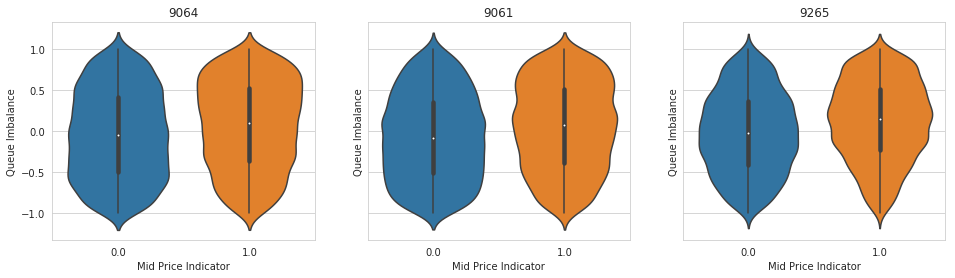

In [5]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
i = 0
plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')
for k, d in d_stocks.items():
    sns.violinplot(y=d['queue_imbalance'], x=d['mid_price_indicator'], ax=ax[i])
    ax[i].set_title(k)
    ax[i].set_ylabel('Queue Imbalance')
    ax[i].set_xlabel('Mid Price Indicator')
    i += 1

plt.ylabel('Queue Imbalance')
plt.xlabel('Mid Price Indicator')
if should_save_fig:
    plt.savefig('violin_plot_imb_vs_ind.png')

Text(0.5,1,'Queue Imbalance vs Mid Price Indicator')

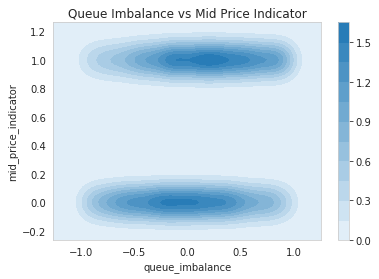

In [6]:
sns.kdeplot(d['queue_imbalance'], d['mid_price_indicator'], shade=True, cbar=True)
plt.title('Queue Imbalance vs Mid Price Indicator')

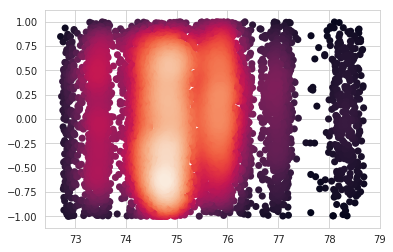

<Figure size 432x288 with 0 Axes>

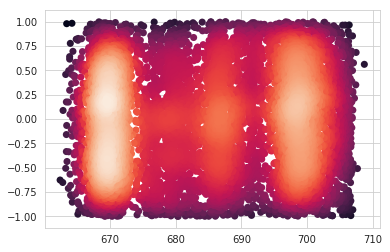

<Figure size 432x288 with 0 Axes>

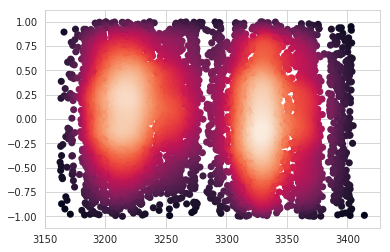

<Figure size 432x288 with 0 Axes>

In [7]:
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[0]], 0, len(d_stocks[stocks[0]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[1]], 0, len(d_stocks[stocks[1]]))
lob.plot_density_imbalance_vs_mid(d_stocks[stocks[2]], 0, len(d_stocks[stocks[2]]))

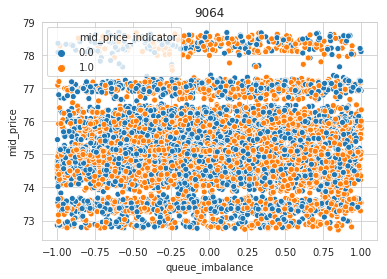

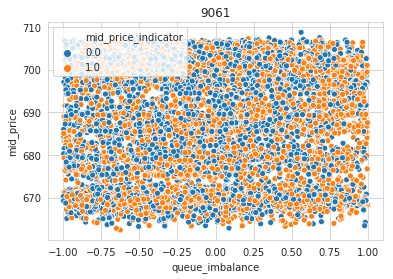

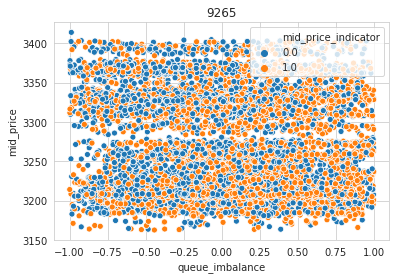

<Figure size 432x288 with 0 Axes>

In [8]:
for k, d in d_stocks.items():
    sns.scatterplot(d['queue_imbalance'], d['mid_price'], hue=d['mid_price_indicator'])
    plt.title(k)
    plt.figure()

#### Mid Price Visualization

8000
8000
8000


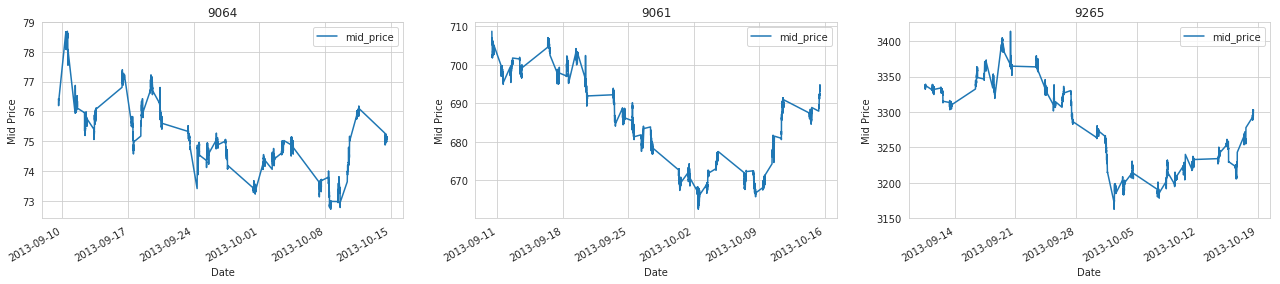

In [9]:
f, ax = plt.subplots(1, 3, figsize=(22, 4))
for i in range(len(stocks)):
    print(len(d_stocks[stocks[i]]))
    d_stocks[stocks[i]][['mid_price']].plot(label=stocks[i], ax=ax[i])
    ax[i].set_title(stocks[i])
    ax[i].set_ylabel('Mid Price')
    ax[i].set_xlabel('Date')
    ax[i].legend()

plt.legend()
if should_save_fig:
    print('Saving figure')
    plt.savefig('mid_price.png')

## Logistic

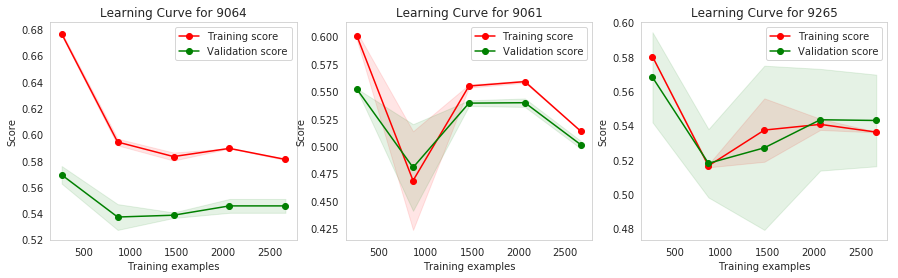

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=2), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
if should_save_fig:
    print('Saving figure')
    plt.savefig('logistic_regression_learning_curves.png')

8000 2000
8000 2000
8000 2000


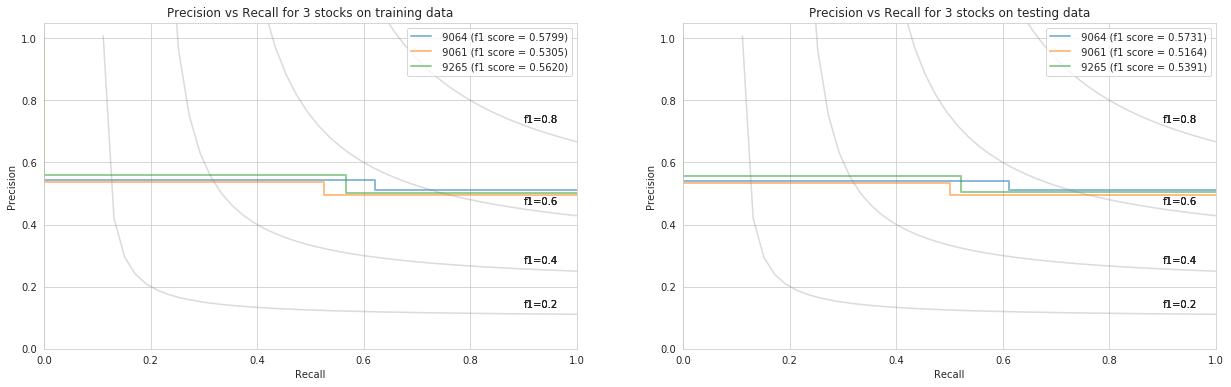

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    print(len(d_stocks[stock]), len(d_test_stocks[stock]) )
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data')
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax2,
                 title='Precision vs Recall for 3 stocks on testing data')
    if should_save_fig:
        print('Saving figure')
        plt.savefig('logistic_regression_precision_vs_recall.png')

In [12]:
def get_scores_dict_for_data(functions_to_run, dfs, clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = LogisticRegression(random_state=0) #21312)
    res_train = model.validate_model(log_clf, d_stocks[stock][['queue_imbalance']], 
                         d_stocks[stock]['mid_price_indicator'])
    dfs = {'test': d_test_stocks[stock]}
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    

    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [13]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.552281,0.083125,0.083860,0.549561,0.560276,0.541642,9064,0.561354,0.064688,0.064892,0.541251,0.583008,0.532283,0.577705,0.098840,0.099385,0.551937,0.606094,0.549329
9061,0.503022,0.095897,0.098354,0.550373,0.470231,0.548135,9061,0.485511,0.057771,0.058480,0.530466,0.447581,0.528850,0.506639,0.078463,0.079065,0.534294,0.483654,0.539110
9265,0.544099,0.114148,0.115615,0.562462,0.532477,0.557136,9265,0.541284,0.100540,0.100733,0.558947,0.524704,0.550307,0.535878,0.123566,0.124028,0.558095,0.516015,0.561661


In [14]:
df_scores[['matthews', 'test_matthews']]

,matthews,test_matthews
9064,0.083860,0.064892
9061,0.098354,0.058480
9265,0.115615,0.100733


In [15]:
print('log')
df_scores[['roc_auc', 'test_roc_auc']]

log


,roc_auc,test_roc_auc
9064,0.541642,0.532283
9061,0.548135,0.528850
9265,0.557136,0.550307


In [16]:
print(df_scores[['matthews', 'test_matthews', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  matthews &  test\_matthews &   roc\_auc &  test\_roc\_auc \\
\midrule
9064 &  0.083860 &       0.064892 &  0.541642 &      0.532283 \\
9061 &  0.098354 &       0.058480 &  0.548135 &      0.528850 \\
9265 &  0.115615 &       0.100733 &  0.557136 &      0.550307 \\
\bottomrule
\end{tabular}



In [17]:
print(df_scores[['f1', 'test_f1_score', 'precision', 'test_precision', 'recall', 'test_recall']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        f1 &  test\_f1\_score &  precision &  test\_precision &    recall &  test\_recall \\
\midrule
9064 &  0.552281 &       0.561354 &   0.549561 &        0.541251 &  0.560276 &     0.583008 \\
9061 &  0.503022 &       0.485511 &   0.550373 &        0.530466 &  0.470231 &     0.447581 \\
9265 &  0.544099 &       0.541284 &   0.562462 &        0.558947 &  0.532477 &     0.524704 \\
\bottomrule
\end{tabular}



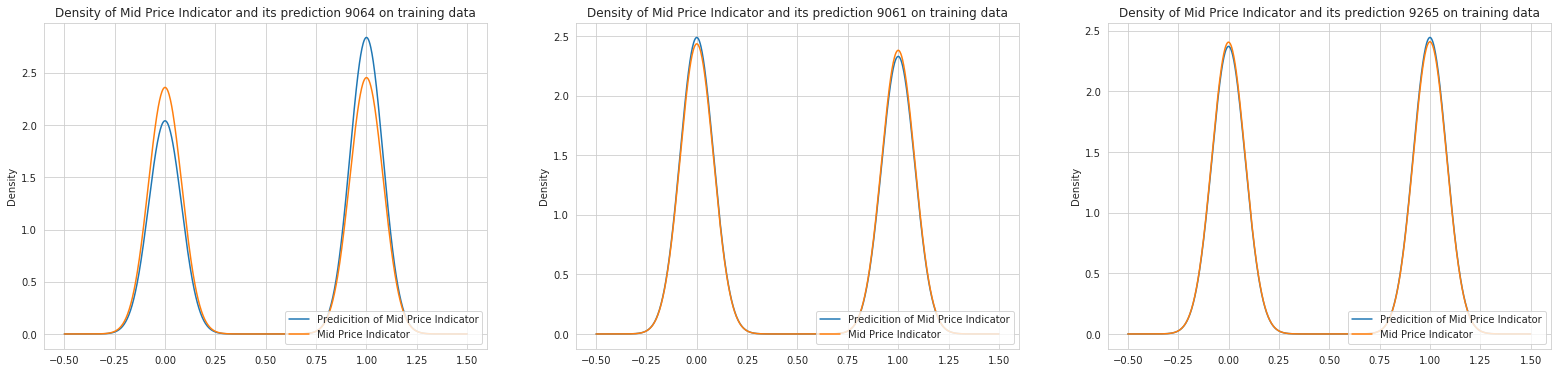

In [18]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    d_stocks[stock][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(stock))
    ax[i].legend(loc='lower right')
if should_save_fig:
    print('Saving figure')
    plt.savefig('density_of_mid_price_and_prediction_training_data.png')

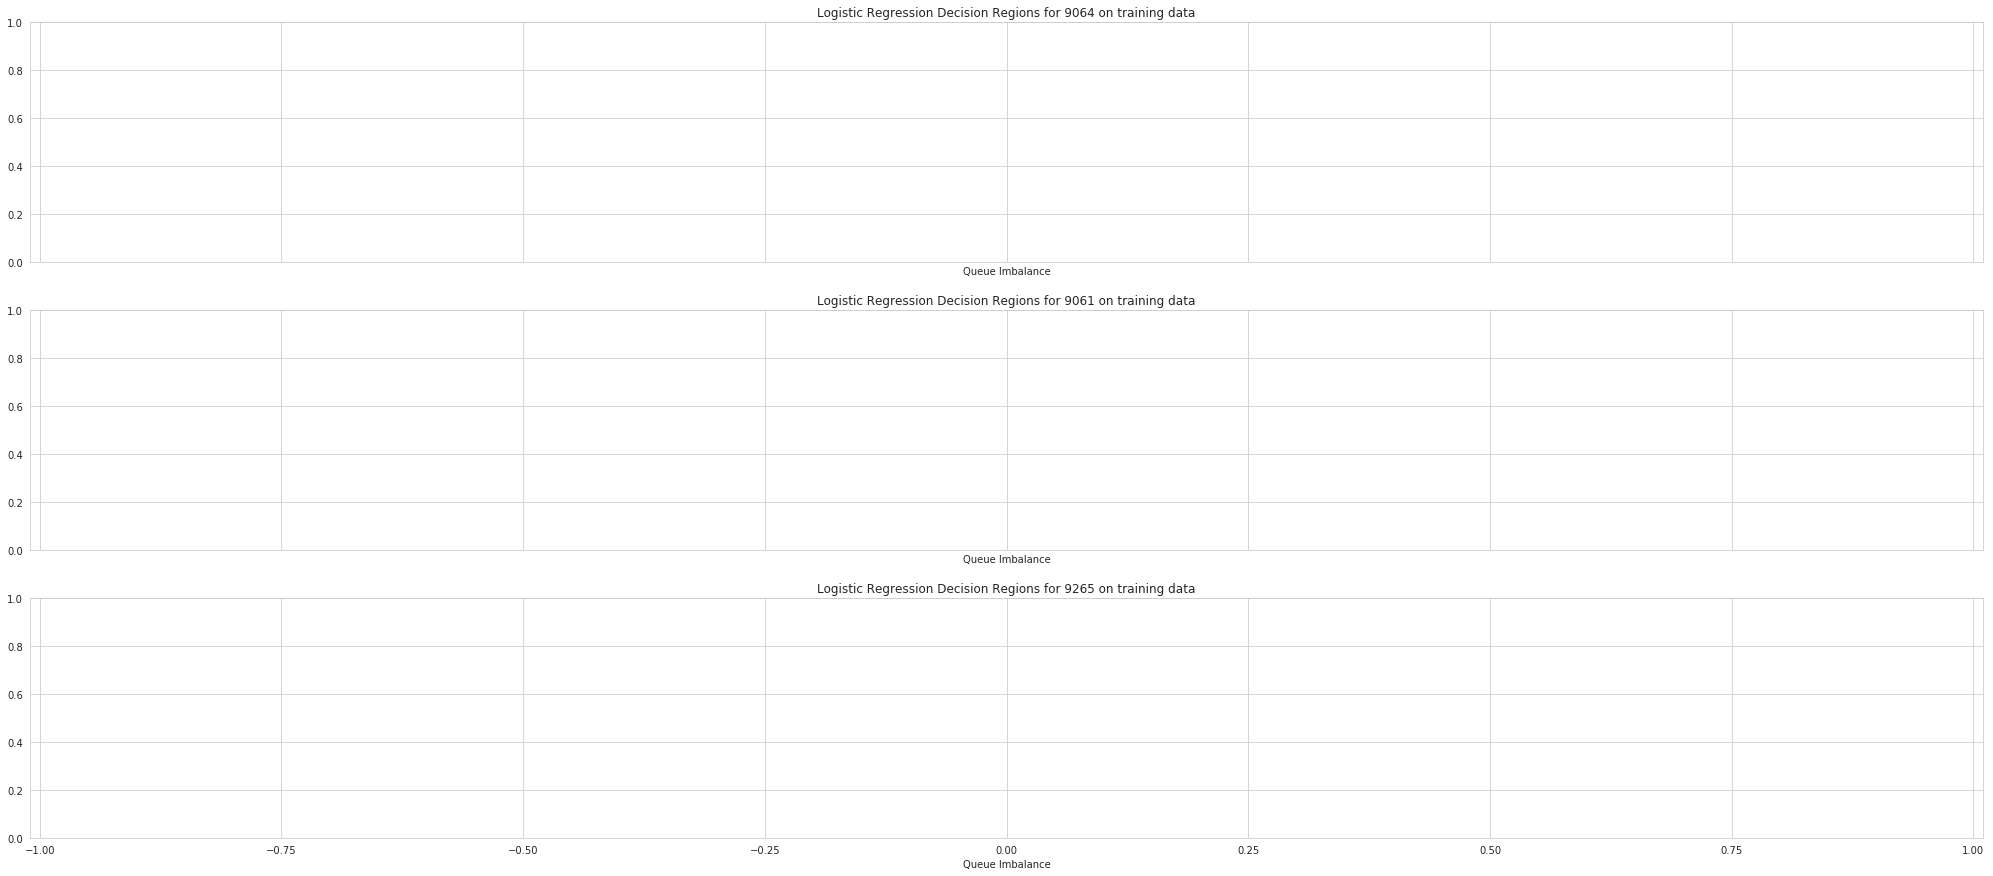

In [19]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    X = df[['queue_imbalance']].values
    y = df['mid_price_indicator'].values.astype(np.integer)

    clf = lob.logistic_regression(df, 0, len(df))
   # plot_decision_regions(X[0:900], y[0:900], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('Logistic Regression Decision Regions for {} on training data'.format(stock))
    ax[i].set_xlim(-1.01, 1.01)

if should_save_fig:
    print('Saving figure')
    plt.savefig('logistic_regression_decision_region.png'.format(s))